NVIDIA-SMI 440.44       Driver Version: 440.44       CUDA Version: 10.2 

In [1]:

import sys,os
#import mrcfile
import cv2
#import skimage
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import glob
import joblib
import torch.nn.functional as F
import importlib
from tensorflow.keras.callbacks import TensorBoard
import zipfile
import warnings
import concurrent.futures
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# 忽略特定类别的警告
warnings.filterwarnings("ignore", category=RuntimeWarning)


# 关闭特定类型的警告
warnings.filterwarnings("ignore", category=DeprecationWarning)

import warnings

# 禁用所有警告
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# 將 denoise.py 所在資料夾加入 Python 的模組搜尋路徑
sys.path.append('/home/m112040012/vscode/NoiseTransfer2clean-main/denoiser/')
import denoise as dn
from utils.data.loader import load_image

importlib.reload(dn)
!nvidia-smi

ModuleNotFoundError: No module named 'torch'

In [2]:
def image_list(folder_path):
    img_data_clean_list = []
    file_names=['sb1_210512 pos 1000 1-1_1.jpg', 'sb1_210512 pos 1000 1-2_1.jpg', \
            'sb1_210512 pos 1000 1-3_1.jpg', 'sb1_210512 pos 1000 2-1_1.jpg', \
            'sb1_210512 pos 1000 3-1_1.jpg']
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)  
        jpg = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img_data_clean_list.append(jpg)
    img_data_clean_list = np.stack(img_data_clean_list, axis=0)
    return img_data_clean_list
    
def plot_list(preprocess_jpg,a):
    plt.figure(figsize=(7, 7))
    plt.imshow(preprocess_jpg[0], cmap='gray')
    plt.show()

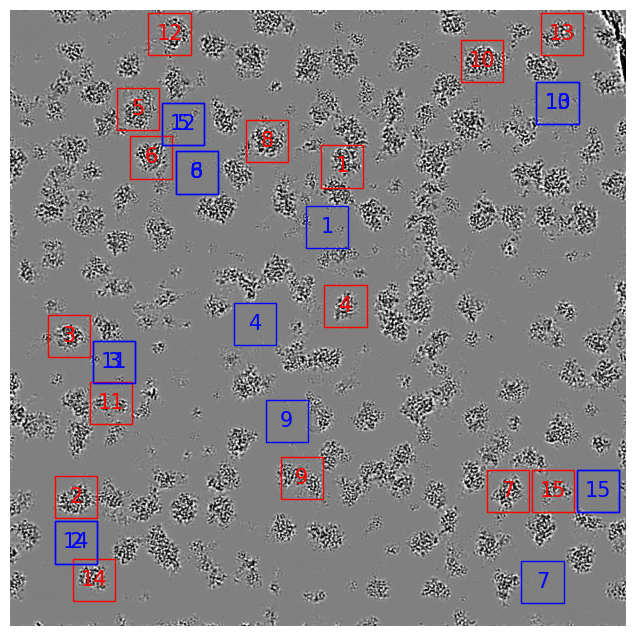

In [10]:
preprocess_jpg=image_list("/home/m112040012/vscode/fine_denoiser_model/wgan_reweight_jpgtojpg_3/pre/")
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(preprocess_jpg[0], cmap='gray')

# 以手動指定的方式添加一個方格，這裡的 [x, y, width, height] 需要根據你的需求進行調整
width, height=280,280
rect_params_list_0 = [(2070, 900), (300, 3100), (250, 2030), (2090, 1830), (710, 520), \
                    (800, 840), (3170, 3060), (1570, 730), (1800, 2970), (3000, 200),\
                    (530, 2470),(920, 20),(3530, 20),(420, 3650),(3470, 3060),\
                    (1970, 1300), (300, 3400), (550, 2200), (1490, 1950), (1010, 620), \
                    (1100, 940), (3400, 3660), (1100, 940), (1700, 2590), (3500, 480), \
                    (550, 2200),(1010, 620),(3500, 480),(300, 3400), (3770, 3060)]


rect_params_list_1 = [(2270, 680), (200, 3300), (450, 2030), (2100, 1700), (580, 420), \
                    (930, 960), (2970, 3130), (1500, 650), (1600, 3050), (3050, 380),\
                      (3320, 1880),(3100, 1210),(450, 3750),(2230, 980),(1600, 1280),\
                     (2760, 740), (150, 3020), (200, 2330), (2200, 1400), (650, 650), \
                    (650, 650), (2300, 3150), (1250, 250), (1900, 3150), (2760, 740),\
                      (2720, 1700),(2720, 1700),(150, 3020),(2760, 740),(2200, 1400)]

rect_params_list_2 = [(2020, 500), (400, 1780), (1280, 1900), (2100, 1700), (540, 240), \
                    (880, 790), (2420, 3300), (1320, 590), (1570, 3000), (3080, 790),\
                      (2970, 3700),(3500, 1600), (3500, 200),(3780, 1200),(3250, 3000),
                    (1720, 650), (650, 1690), (1630, 1700), (1830, 1700), (840, 170), \
                    (550, 750), (2170, 3490), (1620, 650),(2170, 2590), (3260, 490),\
                      (3550, 3250),(3800, 2000), (3260, 490) ,(3260, 490),(3550, 3250)]

rect_params_list_3 = [(2020, 450), (20, 3100), (650, 1800), (2880, 1550), (540, 200), \
                    (1100, 700), (2750, 2370), (1320, 1130), (1400, 2800), (3080, 790),\
                      (3350, 300),(1400, 2100),(3350, 3600), (2830, 1820),(1900, 170),
                     (1920, 690), (500, 3400), (1000, 2570), (2530, 1120), (250, 10), \
                    (1920, 690), (2490, 2270), (1920, 690), (1000, 2570), (2800, 430),\
                      (3620, 330),(1000, 2570),(2400, 3600),(2530, 1120),(1920, 690)]

rect_params_list_4 = [(2070, 420), (80, 2150), (650, 1650), (2700, 1520), (460, 650), \
                    (970, 600), (2880, 2450), (1450, 1130), (1200, 3050), (2880, 890), \
                      (3660, 3680),(1500, 3590), (1630, 1830), (3180, 3330),(1000, 3790),
                    (1870, 460), (1030, 2580), (450, 1500), (2870, 1760), (660, 350), \
                    (860, 350), (2880, 2200), (2050, 1180), (1030, 2580), (2050, 1180), \
                      (3560, 3130),(2230, 3590), (1700, 1630), (3560, 3130),(2230, 3590)]
rectangles_pixels=[]
lista=rect_params_list_0
for i, rect_params in enumerate(lista):
    if i <len(lista)/2:
        rect = Rectangle((rect_params[0], rect_params[1]), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    else:
        rect = Rectangle((rect_params[0], rect_params[1]), width, height, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
    
    # 在方格中心添加數字
    center_x = rect_params[0] + width / 2
    center_y = rect_params[1] + height / 2
    if i <len(lista)/2:
        ax.text(center_x, center_y, str(i+1), color='r', fontsize=15, ha='center', va='center')
    else:
        ax.text(center_x, center_y, int(i+1-len(lista)/2), color='b', fontsize=15, ha='center', va='center')
    x, y, w, h = rect_params[0], rect_params[1], width, height
    rectangle_pixels = img_data_clean_combined[0][y:y+h, x:x+w]
    rectangles_pixels.append(rectangle_pixels)
    
signals=[rectangles_pixels[:10]]    
background=[rectangles_pixels[10]]
    
ax.add_patch(rect)
ax.axis('off')
#plt.title('Synthetic Image with Manual Rectangle')
plt.show()

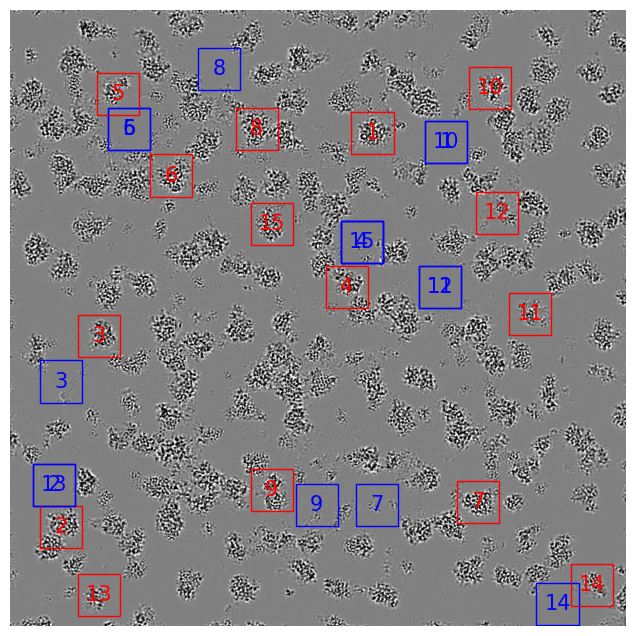

In [37]:
img_data_clean_combined=image_list("/home/m112040012/vscode/fine_denoiser_model/wgan_reweight_jpgtojpg_3/pre/")
#img_data_clean_combined=image_list("/home/m112040012/vscode/fine_denoiser_model/data2_copy_reweight_mrctojpg_6/pre/")

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_data_clean_combined[1], cmap='gray')

# 以手動指定的方式添加一個方格，這裡的 [x, y, width, height] 需要根據你的需求進行調整
width, height=280,280
rect_params_list_0 = [(2070, 900), (300, 3100), (250, 2030), (2090, 1830), (710, 520), \
                    (800, 840), (3170, 3060), (1570, 730), (1800, 2970), (3000, 200),\
                    (530, 2470),(3230, 20),(1450, 3580),(420, 3650),(3470, 3060),\
                    (1970, 1300), (300, 3400), (550, 2200), (1490, 1950), (1010, 620), \
                    (1100, 940), (3400, 3660), (1100, 940), (1700, 2590), (3500, 480), \
                    (550, 2200),(3150, 440),(1780, 3580),(300, 3400), (3770, 3060)]


rect_params_list_1 = [(2270, 680), (200, 3300), (450, 2030), (2100, 1700), (580, 420), \
                    (930, 960), (2970, 3130), (1500, 650), (1600, 3050), (3050, 380),\
                      (3320, 1880),(3100, 1210),(450, 3750),(3730, 3680),(1600, 1280),\
                     (2760, 740), (150, 3020), (200, 2330), (2200, 1400), (650, 650), \
                    (650, 650), (2300, 3150), (1250, 250), (1900, 3150), (2760, 740),\
                      (2720, 1700),(2720, 1700),(150, 3020),(3500, 3810),(2200, 1400)]

rect_params_list_2 = [(2020, 500), (400, 1780), (1280, 1900), (2100, 1700), (540, 240), \
                    (880, 790), (2420, 3300), (1320, 590), (1570, 3000), (3080, 790),\
                      (2970, 3700),(3500, 1600), (3500, 200),(3780, 1200),(3250, 3000),
                    (1720, 650), (650, 1690), (1630, 1700), (1830, 1700), (840, 170), \
                    (550, 750), (2170, 3490), (1620, 650),(2170, 2590), (3260, 490),\
                      (3550, 3250),(3800, 2000), (3260, 490) ,(3260, 490),(3550, 3250)]

rect_params_list_3 = [(2020, 450), (20, 3100), (650, 1800), (2880, 1550), (540, 200), \
                    (1100, 700), (2750, 2370), (1320, 1130), (1400, 2800), (3080, 790),\
                      (3350, 300),(1400, 2100),(3350, 3600), (2830, 1820),(1900, 170),
                     (1920, 690), (500, 3400), (1000, 2570), (2530, 1120), (250, 10), \
                    (1920, 690), (2490, 2270), (1920, 690), (1000, 2570), (2800, 430),\
                      (3620, 330),(1000, 2570),(2400, 3600),(2530, 1120),(1920, 690)]

rect_params_list_4 = [(2070, 420), (80, 2150), (650, 1650), (2700, 1520), (460, 650), \
                    (970, 600), (2880, 2450), (1450, 1130), (1200, 3050), (2880, 890), \
                      (3660, 3680),(1500, 3590), (1630, 1830), (3180, 3330),(1000, 3790),
                    (1870, 460), (1030, 2580), (450, 1500), (2870, 1760), (660, 350), \
                    (860, 350), (2880, 2200), (2050, 1180), (1030, 2580), (2050, 1180), \
                      (3560, 3130),(2230, 3590), (1700, 1630), (3560, 3130),(2230, 3590)]
rectangles_pixels=[]
lista=rect_params_list_1
for i, rect_params in enumerate(lista):
    if i <len(lista)/2:
        rect = Rectangle((rect_params[0], rect_params[1]), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    else:
        rect = Rectangle((rect_params[0], rect_params[1]), width, height, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
    
    # 在方格中心添加數字
    center_x = rect_params[0] + width / 2
    center_y = rect_params[1] + height / 2
    if i <len(lista)/2:
        ax.text(center_x, center_y, str(i+1), color='r', fontsize=15, ha='center', va='center')
    else:
        ax.text(center_x, center_y, int(i+1-len(lista)/2), color='b', fontsize=15, ha='center', va='center')
    x, y, w, h = rect_params[0], rect_params[1], width, height
    rectangle_pixels = img_data_clean_combined[0][y:y+h, x:x+w]
    rectangles_pixels.append(rectangle_pixels)
    
signals=[rectangles_pixels[:10]]    
background=[rectangles_pixels[10]]
    
ax.add_patch(rect)
ax.axis('off')
#plt.title('Synthetic Image with Manual Rectangle')
plt.show()

In [11]:
#算單張
# snr_list = []
# total_snr = 0.0
# for i, region_pixels in enumerate(signals[0]):
    
#     mu_b = np.mean(background)
#     var_b = np.var(background)

#     # 定義訊號區域，這裡假設整個區域都是訊號
#     s=region_pixels-background
#     mu_s = np.mean(s)  # 設置為與背景相同的平均值
#     var_s = np.var(s)  # 設置為與背景相同的變異數

#     # 計算區域的平均 SNR（以 dB 為單位）
#     snr =  np.log10(var_s / var_b)

#     # 將 SNR 添加到列表中
#     snr_list.append({
#         'region_index': i + 1,
#         'SNR': snr
#     })
#     total_snr += snr

# # 輸出每個方塊區域的 SNR
# for snr_info in snr_list:
#     print(f"Region {snr_info['region_index']} SNR: {snr_info['SNR']} dB")
# print(total_snr)    


Region 1 SNR: 1.1497529337611399 dB
Region 2 SNR: 1.2251714817842196 dB
Region 3 SNR: 1.1978109005306719 dB
Region 4 SNR: 1.172965940930874 dB
Region 5 SNR: 1.1969797785632577 dB
Region 6 SNR: 1.1613186218654141 dB
Region 7 SNR: 1.2269757727182646 dB
Region 8 SNR: 1.1323113465537988 dB
Region 9 SNR: 1.2434152395396676 dB
Region 10 SNR: 1.22752446222841 dB
11.934226478475715


In [3]:
#算SNR
folder_path="/home/m112040012/vscode/fine_denoiser_model/test/pre/"
#"/home/m112040012/vscode/data/10077/topaz_jpg_mrc/preprocess_jpg/"
#"/home/m112040012/vscode/data/10077/topaz_jpg_mrc/mrc_topaz_pre_jpg/"
#"/home/m112040012/vscode/data/10077/topaz_jpg_mrc/preprocess_topaz_pre_jpg/"
#"/home/m112040012/vscode/data/10077/BM3D/pre/"
#folder_path = "/home/m112040012/vscode/fine_denoiser_model/wgan_reweight_mrctojpg_1/pre/"
#folder_path = "/home/m112040012/vscode/fine_denoiser_model/copy_reweight_mrctojpg_2/pre/"
#folder_path = "/home/m112040012/vscode/fine_denoiser_model/wgan_reweight_jpgtojpg_3/pre/"
#folder_path = "/home/m112040012/vscode/fine_denoiser_model/copy_reweight_jpgtojpg_4/pre/"
#"/home/m112040012/vscode/fine_denoiser_model/data2_copy_reweight_mrctojpg_6/pre/"
#"/home/m112040012/vscode/fine_denoiser_model/data2_wgan_reweight_jpgtojpg_7/pre/"
#"/home/m112040012/vscode/fine_denoiser_model/data2_copy_reweight_jpgtojpg_8/pre/"
#"/home/m112040012/vscode/fine_denoiser_model/data2_wgan_reweight_mrctojpg_5/pre/"
#"/home/m112040012/vscode/fine_denoiser_model/Aspire_gaussian_9/pre/"
#file_names = sorted(os.listdir(folder_path))[:10]
#print(file_names)
img_data_clean_list = []
file_names=['sb1_210512 pos 1000 1-1_1.jpg', 'sb1_210512 pos 1000 1-2_1.jpg', \
            'sb1_210512 pos 1000 1-3_1.jpg', 'sb1_210512 pos 1000 2-1_1.jpg', \
            'sb1_210512 pos 1000 3-1_1.jpg']

# 遍歷所有檔案名稱，找出 JPG 檔案並讀取
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)  # 檔案完整路徑
    jpg = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img_data_clean_list.append(jpg)

img_data_clean_list = np.stack(img_data_clean_list, axis=0)
print(img_data_clean_list.shape)

width, height=280,280

signal=(
    [(2070, 900), (300, 3100), (250, 2030), (2090, 1830), (710, 520), \
                    (800, 840), (3170, 3060), (1570, 730), (1800, 2970), (3000, 200),\
                    (530, 2470),(3230, 20),(1450, 3580),(420, 3650),(3470, 3060)],
    
    [(2270, 680), (200, 3300), (450, 2030), (2100, 1700), (580, 420), \
                    (930, 960), (2970, 3130), (1500, 650), (1600, 3050), (3050, 380),\
                      (3320, 1880),(3100, 1210),(450, 3750),(3730, 3680),(1600, 1280)],
    
    [(2020, 500), (400, 1780), (1280, 1900), (2100, 1700), (540, 240), \
                    (880, 790), (2420, 3300), (1320, 590), (1570, 3000), (3080, 790),\
                      (2970, 3700),(3500, 1600), (3500, 200),(3780, 1200),(3250, 3000)],
    
    [(2020, 450), (20, 3100), (650, 1800), (2880, 1550), (540, 200), \
                    (1100, 700), (2750, 2370), (1320, 1130), (1400, 2800), (3080, 790),\
                      (3350, 300),(1400, 2100),(3350, 3600), (2830, 1820),(1900, 170)],
    
    [(2070, 420), (80, 2150), (650, 1650), (2700, 1520), (460, 650), \
                    (970, 600), (2880, 2450), (1450, 1130), (1200, 3050), (2880, 890), \
                      (3660, 3680),(1500, 3590), (1630, 1830), (3180, 3330),(1000, 3790),]
)

background=(
    [ (1970, 1300), (300, 3400), (550, 2200), (1490, 1950), (1010, 620), \
                    (1100, 940), (3400, 3660), (1100, 940), (1700, 2590), (3500, 480), \
                    (550, 2200),(3150, 440),(1780, 3580),(300, 3400), (3770, 3060)] ,
    
    [(2760, 740), (150, 3020), (200, 2330), (2200, 1400), (650, 650), \
                    (650, 650), (2300, 3150), (1250, 250), (1900, 3150), (2760, 740),\
                      (2720, 1700),(2720, 1700),(150, 3020),(3500, 3810),(2200, 1400)] ,
    
    [ (1720, 650), (650, 1690), (1630, 1700), (1830, 1700), (840, 170), \
                    (550, 750), (2170, 3490), (1620, 650),(2170, 2590), (3260, 490),\
                      (3550, 3250),(3800, 2000), (3260, 490) ,(3260, 490),(3550, 3250)] ,
    
    [(1920, 690), (500, 3400), (1000, 2570), (2530, 1120), (250, 10), \
                    (1920, 690), (2490, 2270), (1920, 690), (1000, 2570), (2800, 430),\
                      (3620, 330),(1000, 2570),(2400, 3600),(2530, 1120),(1920, 690)] ,
    
    [(1870, 460), (1030, 2580), (450, 1500), (2870, 1760), (660, 350), \
                    (860, 350), (2880, 2200), (2050, 1180), (1030, 2580), (2050, 1180), \
                      (3560, 3130),(2230, 3590), (1700, 1630), (3560, 3130),(2230, 3590)]
)


# 將所有的區域像素數據存儲到列表中

i=0
# 將所有的區域像素數據存儲到列表中
new_signal_15 = [pair[:] for pair in signal]  #[-10:] 7clean+3not clean
new_background_15 = [pair[:] for pair in background]
new_signal_10clean = [pair[:10] for pair in signal]  #[-10:] 7clean+3not clean
new_background_10clean = [pair[:10] for pair in background]
new_signal_55 = [pair[-10:] for pair in signal]  
new_background_55 = [pair[-10:] for pair in background]

def psnr(new_signal,new_background):
    background_pixels = []
    signal_pixels = []
    for i, (img, signal, background) in enumerate(zip(img_data_clean_list, new_signal, new_background)):
        for j in range(len(signal)):
            background_2=background[j]
            signal_2=signal[j]
            x_bg, y_bg, w_bg, h_bg = background_2[0], background_2[1], width, height
            x, y, w, h             = signal_2[0], signal_2[1], width, height
            background_img = img[y_bg:y_bg+h_bg, x_bg:x_bg+w_bg]
            signal_img = img[y:y+h, x:x+w]  
            background_pixels.append(background_img)
            signal_pixels.append(signal_img)
    print(len(signal_pixels))
    snr_list = []
    
    total_snr = 0.0
    for i, (signal_img,background_img) in enumerate(zip(signal_pixels,background_pixels)):

        mu_b = np.mean(background_img)
        var_b = np.var(background_img)

        # 定義訊號區域，這裡假設整個區域都是訊號
        s=signal_img-mu_b
        mu_s = np.mean(s)  # 設置為與背景相同的平均值
        var_s = np.var(s)  # 設置為與背景相同的變異數

        # 計算區域的平均 SNR（以 dB 為單位）
        snr =  np.log10(var_s / var_b)

        # 將 SNR 添加到列表中
        snr_list.append({
            'region_index': i + 1,
            'SNR': snr
        })
        total_snr += snr
    total_snr_f=(10/len(signal_pixels))*total_snr
    return total_snr_f
# 輸出每個方塊區域的 SNR
#for snr_info in snr_list:
    #print(f"Region {snr_info['region_index']} SNR: {snr_info['SNR']} dB")
total_snr_15=psnr(new_signal_15,new_background_15)
total_snr_10=psnr(new_signal_10clean,new_background_10clean)
total_snr_55=psnr(new_signal_55,new_background_55)
print(f'total_snr_10clean:{total_snr_10} \ntotal_snr_5+5:{total_snr_55}\ntotal_snr_10+5:{total_snr_15}')  

(5, 4096, 4096)
75
50
50
total_snr_10clean:19.78967325680655 
total_snr_5+5:17.58668283976251
total_snr_10+5:18.47480556837459


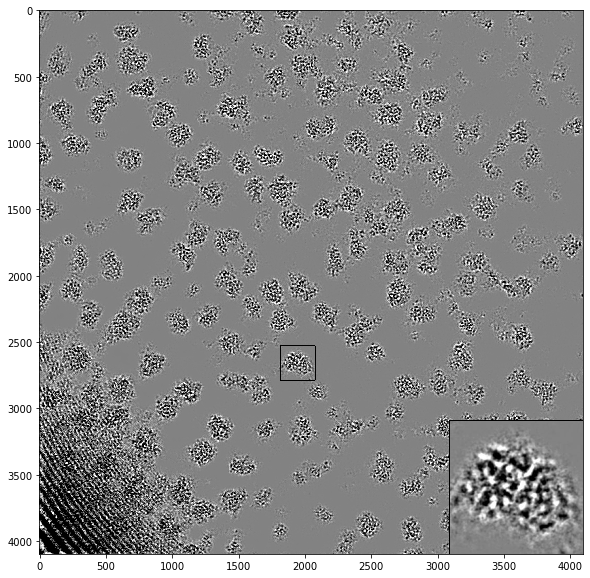

True

In [6]:
#畫細節圖
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 載入主圖片（4096x4096） wgan_reweight_mrctojpg_1
main_image_path = "/home/m112040012/vscode/fine_denoiser_model/test/pre/sb1_210512 pos 1000 1-3_1.jpg"
main_image = cv2.imread(main_image_path, cv2.IMREAD_GRAYSCALE)

# 指定局部放大圖片的大小和位置
w_small, h_small = 256, 256
w_large, h_large = 1000, 1000
x, y = 1820, 2530

# 透過 crop 方法裁剪出局部放大圖片
signal_img = main_image[y:y+h_small, x:x+w_small]
signal_img_resized = cv2.resize(signal_img, (w_large, h_large))

# 獲取主圖片的大小
main_width, main_height = main_image.shape[::-1]  # 因為 OpenCV 的 shape 是反的

# 計算局部放大圖片應該放置的位置（右下角）
position = (main_width - w_large, main_height - h_large)

# 在主圖片上粘貼局部放大圖片之前加上黑框
main_image_copy = main_image.copy()
cv2.rectangle(main_image_copy, (main_width-w_large-5, main_height-h_large-5), (main_width+3, main_height+3), (0, 0, 0), 5)
cv2.rectangle(main_image_copy, (x-2, y-2), (x + w_small+2, y + h_small+2), (0, 0, 255), 5)  # 紅色框
main_image_copy[main_width-w_large:main_width, main_height-h_large:main_height] = signal_img_resized  # 在主圖片上粘貼局部放大圖片

plt.figure(figsize=(10, 10))
plt.imshow(main_image_copy, cmap='gray')
plt.show()

output_image_path = "/home/m112040012/vscode/論文圖/data1_wgan_jpg.jpg"
cv2.imwrite(output_image_path, main_image_copy)

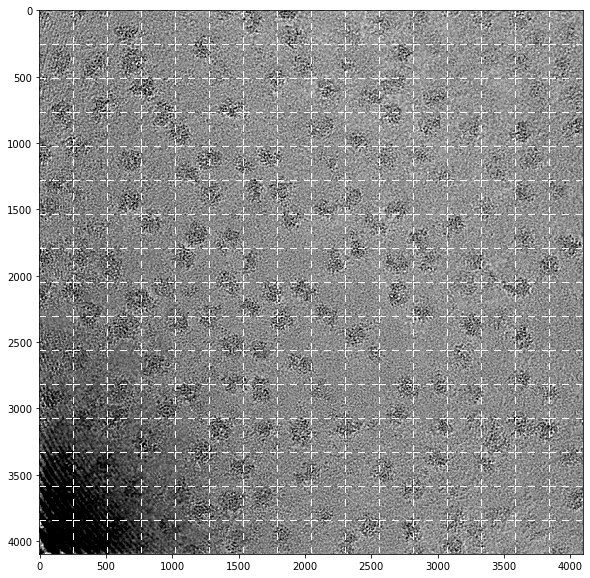

True

In [36]:
#畫圖用
import cv2

# 加载图像
main_image_path = "/home/m112040012/vscode/data/10077/topaz_jpg_mrc/mrc_topaz_pre_jpg/sb1_210512 pos 1000 1-3_1.jpg"
main_image = cv2.imread(main_image_path, cv2.IMREAD_GRAYSCALE)

# 获取图像尺寸
image_height, image_width = main_image.shape

# 设置方框大小
box_size = 256

# 绘制不重叠的虚线方框
for y in range(0, image_height, box_size):
    for x in range(0, image_width, box_size):
        # 确保方框不会超出图像范围
        if x + box_size <= image_width and y + box_size <= image_height:
            # 绘制虚线方框
               for i in range(0, box_size, 100):  # 每20像素绘制一个线段，线段长度为10像素
                    pt1 = (x + i, y)
                    pt2 = (x + i + 50, y)
                    cv2.line(main_image, pt1, pt2, (255, 255, 255), 5)

                    pt1 = (x, y + i)
                    pt2 = (x, y + i + 50)
                    cv2.line(main_image, pt1, pt2, (255, 255, 255), 5)

                    pt1 = (x + box_size, y + i)
                    pt2 = (x + box_size, y + i + 50)
                    cv2.line(main_image, pt1, pt2, (255, 255, 255), 5)

                    pt1 = (x + i, y + box_size)
                    pt2 = (x + i + 50, y + box_size)
                    cv2.line(main_image, pt1, pt2, (255, 255, 255), 5)

# 显示图像
plt.figure(figsize=(10, 10))
plt.imshow(main_image, cmap='gray')
plt.show()
output_image_path = "/home/m112040012/vscode/論文圖/切256.jpg"
cv2.imwrite(output_image_path, main_image)